In [1]:
import yaml
import os
import datetime
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import pymc3 as pm
import pymc3.distributions.transforms as tr
import shutil
import theano
import theano.tensor as tt
import random
import math
import pandas as pd
from pymc3.math import *

print("Running on PyMC3 v{}".format(pm.__version__))

In /Users/tanavya/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/tanavya/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/tanavya/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/tanavya/opt/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases lat

Running on PyMC3 v3.9.3


In [2]:
def get_situation(w, b):
    if 0 <= w and w <= 3:
        if 1 <= b and b <= 36:
            return 1
        elif 36 <= b and b <= 96:
            return 2
        else:
            return 3
    elif 4 <= w and w <= 6:
        if 1 <= b and b <= 36:
            return 4
        elif 36 <= b and b <= 96:
            return 5
        else:
            return 6
    else:
        if 1 <= b and b <= 36:
            return 7
        elif 36 <= b and b <= 96:
            return 8
        else:
            return 9

In [3]:
def get_outcome(r, wicket):
    if wicket is True:
        return 1
    elif r == 0:
        return 2
    elif r == 1:
        return 3
    elif r == 2:
        return 4
    elif r == 3:
        return 5
    elif r == 4:
        return 6
    elif r == 6:
        return 7
    else:
        return 0

In [4]:
data = pd.read_csv("data/deliveries.csv")

In [5]:
data.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [6]:
matches = pd.read_csv("data/matches.csv")

In [7]:
print("Number of matches in dataset:", len(matches))

Number of matches in dataset: 756


In [8]:
selected_ids = matches[matches["season"] >= 2015]["id"]
selected_data = data[data["match_id"].isin(selected_ids)]

In [9]:
selected_data.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [10]:
noballs_and_wides_count = 0
total_balls = 0
noballs_and_wides = {}
batsmen = []
bowlers = []
situation_data = {}

In [11]:
first_innings = selected_data[selected_data["inning"] == 1]
print("First innings data size:", len(first_innings))

First innings data size: 36516


In [12]:
batsman_index = {}
bowler_index = {}
batsmen = first_innings["batsman"].unique()
bowlers = first_innings["bowler"].unique()
for i in range(len(batsmen)):
    batsman_index[batsmen[i]] = i
for i in range(len(bowlers)):
    bowler_index[bowlers[i]] = i

X = [[] for i in range(9)]
id1 = [[] for i in range(9)]
id2 = [[] for i in range(9)]

for k in range(0, 8):
    noballs_and_wides[k] = 0
for l in range(0, 10):
    situation_data[l] = []

In [13]:
I = len(batsmen)
J = len(bowlers)

In [14]:
current_id = -1
w = 0
b = 0
for i in range(len(first_innings)):
    ball_data = first_innings.iloc[i]
    if current_id != ball_data["match_id"]:
        current_id = ball_data["match_id"]
        w = 0
        b = 0
        
    total_balls += 1
    b += 1
    
    batsman = ball_data["batsman"]
    bowler = ball_data["bowler"]
    
    player_dismissed = False
    if pd.notnull(first_innings["player_dismissed"].iloc[i]):
        player_dismissed = True
        w += 1
        
    if ball_data["wide_runs"] >= 1 or ball_data["noball_runs"] >= 1:
        noballs_and_wides_count += 1
        runs = ball_data["batsman_runs"] # check should be total_runs ?
        noballs_and_wides[get_outcome(runs, player_dismissed)] += 1
        continue
        
    runs = ball_data["batsman_runs"]
    l = get_situation(w, b) - 1
    k = get_outcome(runs, player_dismissed)
    if k == 0:
        continue
    X[l].append(k)
    id1[l].append(batsman_index[batsman])
    id2[l].append(bowler_index[bowler])
    situation_data[l].append((batsman_index[batsman], bowler_index[bowler], k))

In [15]:
noballs_and_wides_count

1225

In [16]:
X = np.asarray([np.array(X[i]) for i in range(9)], dtype=object)
id1 = np.asarray([np.array(id1[i]) for i in range(9)], dtype=object)
id2 = np.asarray([np.array(id2[i]) for i in range(9)], dtype=object)

In [17]:
for i in range(9):
    print("Balls in situation %d: %d" % (i+1, len(X[i])))

Balls in situation 1: 10329
Balls in situation 2: 13629
Balls in situation 3: 1949
Balls in situation 4: 47
Balls in situation 5: 3434
Balls in situation 6: 4497
Balls in situation 7: 2
Balls in situation 8: 181
Balls in situation 9: 1213


In [18]:
INF = 5
testval = [[-INF + x * (2 * INF)/5.0 for x in range(6)] for i in range(0, 9)]
l = [i for i in range(9)]

In [19]:
model = pm.Model()
Print = tt.printing.Print("shape:")
with model:
    delta_1 = pm.Uniform("delta_1", lower=0, upper=1)
    delta_2 = pm.Uniform("delta_2", lower=0, upper=1)
    inv_sigma_sqr = pm.Gamma("sigma^-2", alpha=1.0, beta=1.0)
    inv_tau_sqr = pm.Gamma("tau^-2", alpha=1.0, beta=1.0)
    mu_1 = pm.Normal("mu_1", mu=0, sigma=1/pm.math.sqrt(inv_tau_sqr), shape=len(batsmen))
    mu_2 = pm.Normal("mu_2", mu=0, sigma=1/pm.math.sqrt(inv_tau_sqr), shape=len(bowlers))
    delta = pm.math.ge(l, 3) * delta_1 + pm.math.ge(l, 6) * delta_2
    Print(delta.shape)
    Print(mu_1.shape)
    eta = [pm.Deterministic("eta_" + str(i), mu_1[id1[i]] - mu_2[id2[i]]) for i in range(9)]
    cutpoints = pm.Normal("cutpoints", mu=0, sigma=1/pm.math.sqrt(inv_sigma_sqr), transform=pm.distributions.transforms.ordered, shape=(9,6), testval=testval)
    Print(cutpoints.shape)
    X_ = [pm.OrderedLogistic("X_" + str(i), cutpoints=cutpoints[i], eta=eta[i], observed=X[i]-1) for i in range(9)]

shape: __str__ = [9]
shape: __str__ = [232]
shape: __str__ = [9 6]


In [20]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, mu_2, mu_1, tau^-2, sigma^-2, delta_2, delta_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1925 seconds.


In [27]:
# loc = pm.save_trace(trace)
loc = ".pymc_2.trace"

In [28]:
loc

'.pymc_2.trace'

In [29]:
with model:
    trace = pm.load_trace(loc)

Exception ignored in: <function NpzFile.__del__ at 0x1346dda70>
Traceback (most recent call last):
  File "/Users/tanavya/opt/anaconda3/envs/venv/lib/python3.7/site-packages/numpy/lib/npyio.py", line 223, in __del__
    self.close()
  File "/Users/tanavya/opt/anaconda3/envs/venv/lib/python3.7/site-packages/numpy/lib/npyio.py", line 214, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


/Users/tanavya/opt/anaconda3/envs/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Exception ignored in: <function NpzFile.__del__ at 0x1346dda70>
Traceback (most recent call last):
  File "/Users/tanavya/opt/anaconda3/envs/venv/lib/python3.7/site-packages/numpy/lib/npyio.py", line 223, in __del__
    self.close()
  File "/Users/tanavya/opt/anaconda3/envs/venv/lib/python3.7/site-packages/numpy/lib/npyio.py", line 214, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'
/Users/tanavya/opt/anaconda3/envs/venv/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (35770), generating 

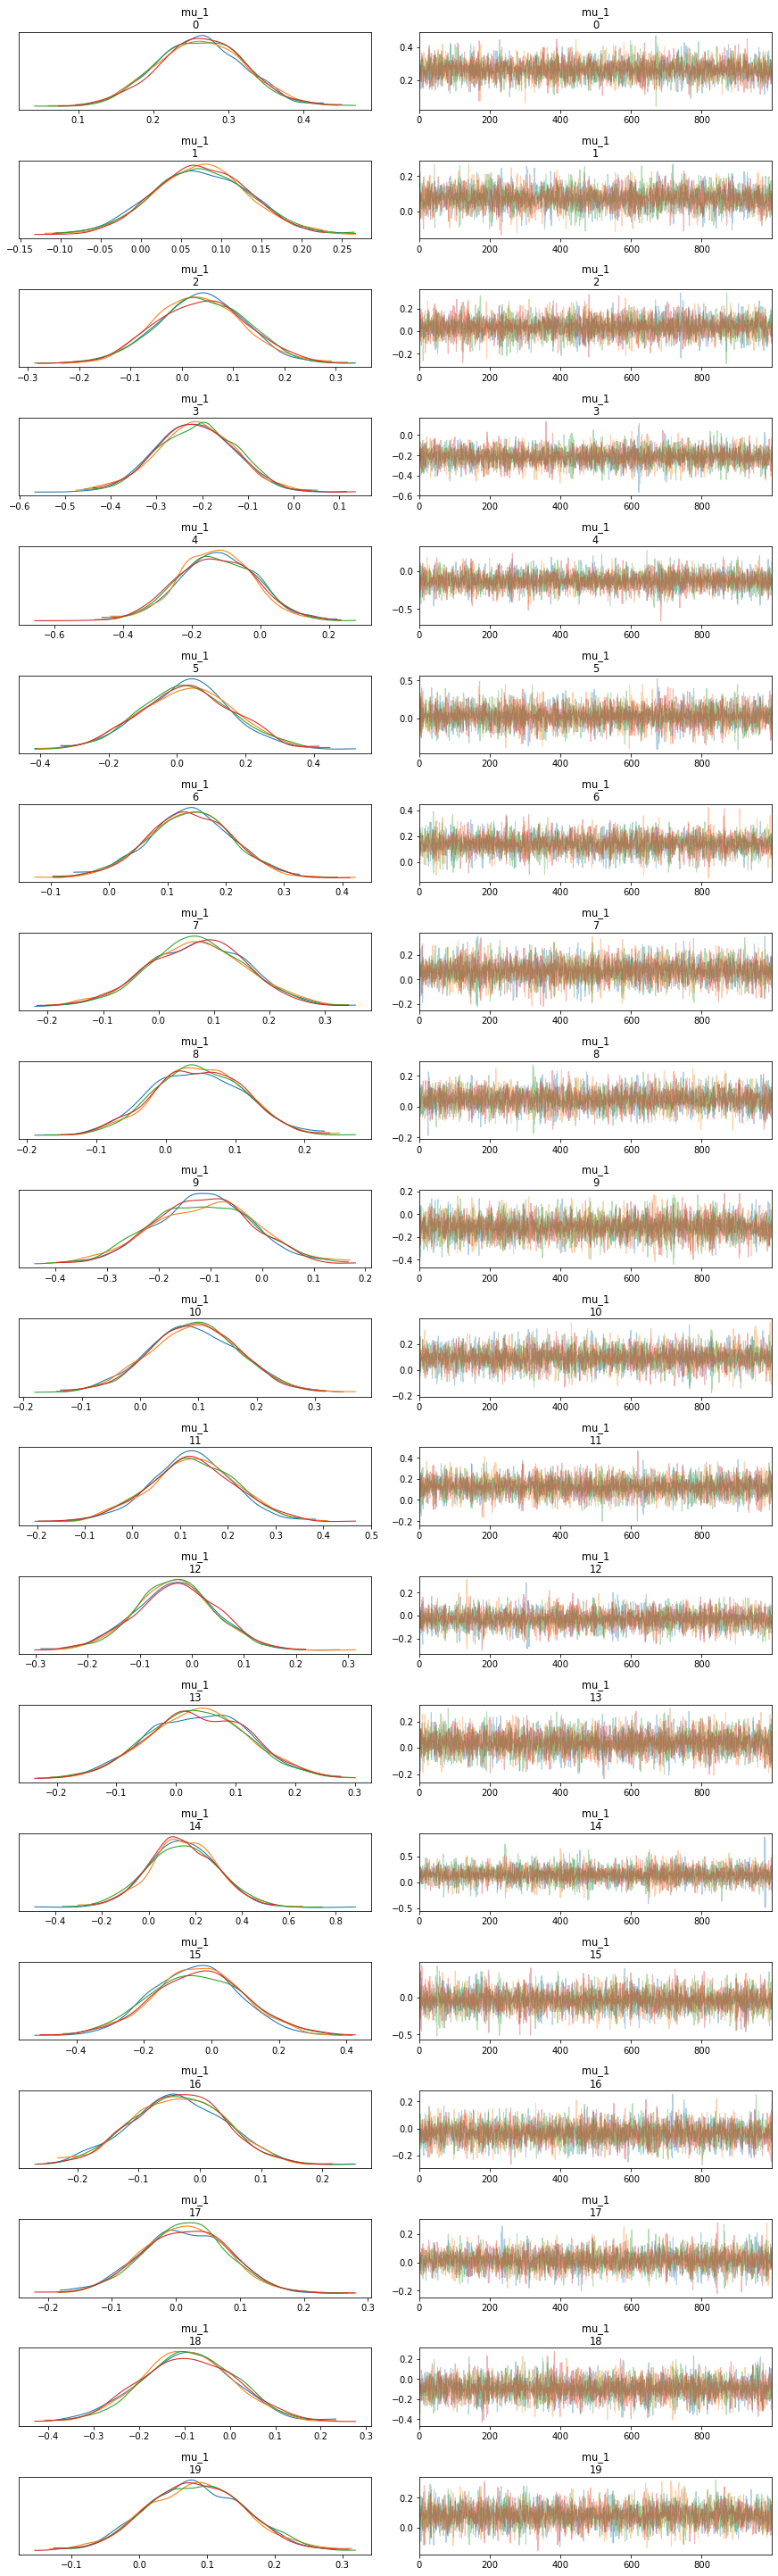

In [34]:
az.plot_trace(trace);

In [35]:
az.summary(trace, round_to=5)

/Users/tanavya/opt/anaconda3/envs/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_1[0],0.26302,0.05728,0.15902,0.36972,0.00082,0.00059,4909.05742,4727.61927,4892.74253,3135.61745,0.99972
mu_1[1],0.07481,0.05945,-0.04080,0.18001,0.00084,0.00072,5025.29184,3419.91394,5030.53528,2697.68987,0.99995
mu_1[2],0.03676,0.08578,-0.13596,0.18125,0.00110,0.00133,6086.81068,2091.19330,6083.63182,2817.90764,1.00110
mu_1[3],-0.21416,0.08513,-0.37092,-0.05504,0.00115,0.00088,5476.51847,4633.33299,5459.34170,2901.01914,1.00058
mu_1[4],-0.12772,0.11224,-0.33953,0.08096,0.00149,0.00138,5687.89777,3328.39739,5710.29969,2842.10010,1.00203
...,...,...,...,...,...,...,...,...,...,...,...
"cutpoints[8,1]",-0.25473,0.06449,-0.37366,-0.13431,0.00103,0.00073,3942.05615,3854.89423,3927.28061,3270.85998,0.99969
"cutpoints[8,2]",1.15514,0.07242,1.01679,1.29066,0.00112,0.00080,4147.99025,4147.99025,4171.61575,3278.16975,0.99970
"cutpoints[8,3]",1.66166,0.08295,1.49973,1.81390,0.00125,0.00088,4421.53318,4421.53318,4430.83004,3327.07153,0.99981
"cutpoints[8,4]",1.70552,0.08400,1.53920,1.85853,0.00124,0.00088,4566.50458,4566.50458,4573.79137,3315.31734,0.99958


In [36]:
cutpoints = np.mean(trace.get_values("cutpoints", burn=500, combine=True), axis=0)

In [37]:
cutpoints

array([[-3.28259369, -0.10364891,  1.1867894 ,  1.42104778,  1.45045344,
         3.29189679],
       [-3.4005771 , -0.81792027,  1.270045  ,  1.74582734,  1.76160637,
         2.90668085],
       [-3.16291772, -1.40464249,  0.45961673,  1.00283821,  1.01616862,
         2.11745666],
       [-1.30235781,  0.5024698 ,  1.49477095,  1.92269025,  2.09088009,
         4.45874996],
       [-2.50071872, -0.3922965 ,  1.62823691,  2.11431761,  2.13550781,
         3.30064272],
       [-2.43455396, -0.95023624,  0.79023234,  1.2806655 ,  1.30206059,
         2.29762695],
       [-1.57049468, -0.80708813,  0.45648184,  1.10996104,  1.9044313 ,
         3.0980479 ],
       [-1.91149096,  0.33077846,  2.49442093,  2.95954818,  3.21426233,
         4.3235398 ],
       [-1.44609279, -0.25475662,  1.15340161,  1.66036606,  1.70418041,
         2.68746965]])

In [38]:
mu_1 = np.mean(trace.get_values("mu_1", burn=500, combine=True), axis=0)
mu_2 = np.mean(trace.get_values("mu_2", burn=500, combine=True), axis=0)

In [39]:
mu_1_sorted = sorted([(mu_1[i], batsmen[i]) for i in range(len(mu_1))])
mu_2_sorted = sorted([(mu_2[i], bowlers[i]) for i in range(len(mu_2))])

In [40]:
mu_1_sorted

[(-0.22826692299382098, 'CJ Anderson'),
 (-0.22039129824191578, 'S Hetmyer'),
 (-0.21263376486388733, 'Yuvraj Singh'),
 (-0.194788755612782, 'PP Chawla'),
 (-0.17950648170788613, 'AD Nath'),
 (-0.17495987463273222, 'K Paul'),
 (-0.17208303748939469, 'UBT Chand'),
 (-0.16943047515066087, 'AP Tare'),
 (-0.1668675201245065, 'NV Ojha'),
 (-0.15675016633446628, 'MS Dhoni'),
 (-0.15096712894735126, 'D Short'),
 (-0.14366473198214105, 'Harbhajan Singh'),
 (-0.14093312083935014, 'STR Binny'),
 (-0.14063744357567778, 'NM Coulter-Nile'),
 (-0.13741461654208506, 'Vishnu Vinod'),
 (-0.13089662277187838, 'CR Woakes'),
 (-0.1291625941292535, 'Shakib Al Hasan'),
 (-0.1289513095967188, 'N Naik'),
 (-0.1283168573480668, 'DJ Hooda'),
 (-0.12271359749796976, 'NLTC Perera'),
 (-0.11637237409654119, 'T Curran'),
 (-0.115499806644619, 'J Archer'),
 (-0.11101800685700536, 'N Rana'),
 (-0.11066968169757954, 'PJ Sangwan'),
 (-0.10228757092333114, 'PSP Handscomb'),
 (-0.10097790973825992, 'EJG Morgan'),
 (-0.09

In [41]:
mu_2_sorted

[(-0.24357969920822728, 'Karanveer Singh'),
 (-0.20748454675508027, 'JP Faulkner'),
 (-0.2039291559794585, 'Basil Thampi'),
 (-0.20294032884838117, 'KA Pollard'),
 (-0.1997907256512234, 'P R Barman'),
 (-0.19731248716188457, 'R Vinay Kumar'),
 (-0.1938921419425042, 'BCJ Cutting'),
 (-0.17206191627846493, 'BB Sran'),
 (-0.15008176976755144, 'K Gowtham'),
 (-0.14777262331662624, 'S Kaushik'),
 (-0.1441469559130655, 'C de Grandhomme'),
 (-0.14374141600983936, 'P Krishna'),
 (-0.14126756877202581, 'SA Abbott'),
 (-0.13323125282220466, 'Parvez Rasool'),
 (-0.12922914400867613, 'Shivam Sharma'),
 (-0.12513585616535627, 'GS Sandhu'),
 (-0.12487692827253723, 'JA Morkel'),
 (-0.12213466972061762, 'MP Stoinis'),
 (-0.11980983908279715, 'Yuvraj Singh'),
 (-0.11965777648241234, 'CJ Anderson'),
 (-0.11926552324158543, 'A Singh'),
 (-0.11748449722110807, 'H Viljoen'),
 (-0.1126299671646192, 'CR Brathwaite'),
 (-0.11246788197077826, 'SB Jakati'),
 (-0.10750154779059934, 'L Ferguson'),
 (-0.1072264491

In [42]:
print(mu_1.shape)
print(mu_2.shape)

(232,)
(199,)


In [43]:
l = [i for i in range(9)]
delta_1 = np.mean(trace.get_values("delta_1", burn=500, combine=True), axis=0)
delta_2 = np.mean(trace.get_values("delta_1", burn=500, combine=True), axis=0)
delta = np.greater_equal(l, 3) * delta_1 + np.greater_equal(l, 6) * delta_2

In [44]:
delta

array([0.        , 0.        , 0.        , 0.50002921, 0.50002921,
       0.50002921, 1.00005842, 1.00005842, 1.00005842])

In [45]:
p = np.zeros(shape = (len(batsmen),len(bowlers),9,7))
for i in range(len(batsmen)):
    for j in range(len(bowlers)):
        for l in range(9):
            for k in range(7):
                if k == 0:
                    p[i,j,l,k] = 1/(1 + np.exp(-(cutpoints[l,k] - mu_1[i] + mu_2[j] - delta[l])))
                elif k == 6:
                    p[i,j,l,k] = 1 - 1/(1 + np.exp(-(cutpoints[l,k-1] - mu_1[i] + mu_2[j] - delta[l])))
                else:
                    p[i,j,l,k] = 1/(1 + np.exp(-(cutpoints[l,k] - mu_1[i] + mu_2[j] - delta[l]))) - 1/(1 + np.exp(-(cutpoints[l,k-1] - mu_1[i] + mu_2[j] - delta[l])))
                    
# TODO: can be vectorised

In [46]:
pw = np.zeros(shape=7)          
for i in range(7):
    pw[i] =  float(noballs_and_wides[i])/noballs_and_wides_count
v = float(noballs_and_wides_count)/total_balls

In [47]:
# Chosen match: Sunrisers Hyderabad vs Royal Challengers Bangalore 2017
batting_team = "Sunrisers Hyderabad"
bowling_team = "Royal Challengers Bangalore"
selected_data[(selected_data["match_id"] == 1) & (selected_data["inning"] == 1)]["batsman"].unique()

array(['DA Warner', 'S Dhawan', 'MC Henriques', 'Yuvraj Singh',
       'DJ Hooda', 'BCJ Cutting'], dtype=object)

In [48]:
for batsman in batsmen:
    if "Nehra" in batsman:
        print(batsman)

A Nehra


In [49]:
batting_order_names = ['DA Warner', 'S Dhawan', 'MC Henriques', 'Yuvraj Singh',
       'DJ Hooda', 'BCJ Cutting', 'NV Ojha', 'B Kumar', 'Bipul Sharma', 'Rashid Khan', 'A Nehra']
batting_order = []
for batsman in batting_order_names:
    batting_order.append(batsman_index[batsman])

In [50]:
batting_order

[0, 1, 2, 3, 4, 5, 55, 58, 122, 57, 142]

In [51]:
current_bowler = ""
bowling_order = []
bowling_order_names = []
for bowler in selected_data[(selected_data["match_id"] == 1) & (selected_data["inning"] == 1)]["bowler"]:
    if bowler != current_bowler:
        current_bowler = bowler
        bowling_order_names.append(bowler)
        bowling_order.append(bowler_index[bowler])

In [52]:
bowling_order_names

['TS Mills',
 'A Choudhary',
 'TS Mills',
 'YS Chahal',
 'S Aravind',
 'SR Watson',
 'YS Chahal',
 'TM Head',
 'YS Chahal',
 'A Choudhary',
 'STR Binny',
 'S Aravind',
 'A Choudhary',
 'SR Watson',
 'S Aravind',
 'YS Chahal',
 'TS Mills',
 'A Choudhary',
 'TS Mills',
 'SR Watson']

In [53]:
bowling_order

[0, 1, 0, 2, 3, 4, 2, 5, 2, 1, 6, 3, 1, 4, 3, 2, 0, 1, 0, 4]

In [54]:
selected_data.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [55]:
columns=["inning", "batting_team", "bowling_team", "over", "ball", "batsman", "non_striker", "bowler", "wide_runs", "batsman_runs", "total_runs", "player_dismissed"]

In [56]:
first_innings = []
X1 = [-1 for i in range(120)]
Y1 = [0 for i in range(120)]
q1 = [0 for i in range(121)]
wickets = 0
runs = 0
q1[0] = (batting_order[0], batting_order[1])

In [57]:
# FIRST INNINGS SIMULATION

for b in range(120):
    
    if wickets == 10:
        X1[b] = -1
        
        
    else:
        wide_runs = 0 
        batsman_runs = 0
        total_runs = 0
        
        j = bowling_order[int(b/6)]
        
        bowler = bowlers[j]
        inning = 1
        over = int(b/6)
        ball = (b%6) + 1

        while np.random.uniform(0, 1) < v:       
            random = np.random.uniform(0, 1)
            Y1[b] = (random > pw[0]) + (random > pw[0] + pw[1]) + (random > pw[0] + pw[1] + pw[2]) + \
                    (random > pw[0] + pw[1] + pw[2] + pw[3]) + (random > pw[0] + pw[1] + pw[2] + pw[3] + pw[4]) + \
                    (random > pw[0] + pw[1] + pw[2] + pw[3] + pw[4] + pw[5])
            # should fix Y1[b] replaces previous Y1[b]
            runs += 1
            wide_runs = 1            
            
            if Y1[b] == 0:
                wickets += 1 # fix wicket fallen on wide/noball
            elif Y1[b] == 1:
    
                runs += 0
            elif Y1[b] == 2:
                wide_runs = 2
                runs += 1
            elif Y1[b] == 3:
                wide_runs = 3
                runs += 2
            elif Y1[b] == 4:
                wide_runs = 4
                runs += 3
            elif Y1[b] == 5:
                wide_runs = 5
                runs += 4
            elif Y1[b] == 6:
                wide_runs = 7
                runs += 6  
            
            if b:
                batsman = batsmen[q1[b-1][0]]
                non_striker = batsmen[q1[b-1][1]]
            else:
                batsman = batsmen[q1[b-1][0]]
                non_striker = batsmen[q1[b-1][1]]
        
            first_innings.append([inning, batting_team, bowling_team, over, ball, batsman, non_striker, bowler, wide_runs, batsman_runs, total_runs, player_dismissed])
        
        #bowler to ball 
        
        l = get_situation(wickets, b+1) - 1
        rand = np.random.uniform(0, 1)
        player_dismissed = None
        
        # following can be simplified
        
        q = q1[b][0]
        
        X1[b] = 0 + (rand > p[q,j,l,0]) + (rand > (p[q,j,l,0]+p[q,j,l,1])) + (rand > (p[q,j,l,0]+p[q,j,l,1]+p[q,j,l,2])) + (rand > (p[q,j,l,0]+p[q,j,l,1]+p[q,j,l,2]+p[q,j,l,3])) + (rand > (p[q,j,l,0]+p[q,j,l,1]+p[q,j,l,2]+p[q,j,l,3]+p[q,j,l,4])) + (rand > (p[q,j,l,0]+p[q,j,l,1]+p[q,j,l,2]+p[q,j,l,3]+p[q,j,l,4]+p[q,j,l,5]))
        print("X1[%d] = %d" % (b, X1[b]))
        
        if X1[b] == 2:
            runs += 1
        elif X1[b] == 3:
            runs += 2
        
        elif X1[b] == 4:
            runs += 3
            
        elif X1[b] == 5 :
            runs += 4
        
        elif X1[b] == 6:
            runs += 6
            
        elif X1[b] == 0:
            wickets += 1
            player_dismissed = batsmen[q1[b][0]]
        
        batsman = batsmen[q1[b][0]]
        non_striker = batsmen[q1[b][1]]
        first_innings.append([inning, batting_team, bowling_team, over, ball, batsman, non_striker, bowler, wide_runs, batsman_runs, total_runs, player_dismissed])
        
        if X1[b] == 0:
            q1[b+1] = (batting_order[wickets + 1], q1[b][1])
        else:
            q1[b+1] = q1[b]
        
        if ((b+1) % 6) == 0 and not (X1[b] == 2 or X1[b] == 4):
            q1[b+1] = (q1[b+1][1], q1[b+1][0])

0 5
1 2
2 1
3 1
4 1
5 1
6 1
7 5
8 1
9 6
10 5
11 2
12 2
13 6
14 1
15 2
16 2
17 5
18 2
19 2
20 1
21 0
22 5
23 6
24 1
25 2
26 0
27 1
28 5
29 0
30 1
31 2
32 2
33 1
34 5
35 1
36 2
37 2
38 1
39 2
40 1
41 2
42 1
43 1
44 1
45 2
46 1
47 6
48 2
49 2
50 3
51 1
52 2
53 2
54 2
55 2
56 2
57 1
58 6
59 2
60 2
61 1
62 5
63 2
64 1
65 1
66 2
67 2
68 2
69 3
70 5
71 2
72 2
73 1
74 2
75 2
76 1
77 1
78 1
79 6
80 1
81 0
82 2
83 5
84 1
85 2
86 2
87 1
88 1
89 5
90 6
91 1
92 2
93 0
94 5
95 2
96 2
97 5
98 5
99 2
100 0
101 1
102 2
103 1
104 0
105 3
106 2
107 2
108 1
109 6
110 1
111 6
112 6
113 5
114 1
115 6
116 2
117 5
118 2
119 6


In [58]:
first_innings_df = pd.DataFrame(first_innings, columns = columns)

In [59]:
first_innings_df

,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,wide_runs,batsman_runs,total_runs,player_dismissed
0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0,1,DA Warner,S Dhawan,TS Mills,0,0,0,None
1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0,2,DA Warner,S Dhawan,TS Mills,0,0,0,None
2,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0,3,DA Warner,S Dhawan,TS Mills,0,0,0,None
3,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0,4,DA Warner,S Dhawan,TS Mills,0,0,0,None
4,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0,5,DA Warner,S Dhawan,TS Mills,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
117,1,Sunrisers Hyderabad,Royal Challengers Bangalore,19,2,B Kumar,Bipul Sharma,SR Watson,0,0,0,None
118,1,Sunrisers Hyderabad,Royal Challengers Bangalore,19,3,B Kumar,Bipul Sharma,SR Watson,0,0,0,None
119,1,Sunrisers Hyderabad,Royal Challengers Bangalore,19,4,B Kumar,Bipul Sharma,SR Watson,0,0,0,None
120,1,Sunrisers Hyderabad,Royal Challengers Bangalore,19,5,B Kumar,Bipul Sharma,SR Watson,0,0,0,None


In [60]:
first_innings_df[pd.notnull(first_innings_df["player_dismissed"])]

,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,wide_runs,batsman_runs,total_runs,player_dismissed
22,1,Sunrisers Hyderabad,Royal Challengers Bangalore,3,4,DA Warner,S Dhawan,YS Chahal,0,0,0,DA Warner
27,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,3,S Dhawan,MC Henriques,S Aravind,0,0,0,S Dhawan
30,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,6,Yuvraj Singh,MC Henriques,S Aravind,0,0,0,Yuvraj Singh
83,1,Sunrisers Hyderabad,Royal Challengers Bangalore,13,4,MC Henriques,DJ Hooda,SR Watson,0,0,0,MC Henriques
95,1,Sunrisers Hyderabad,Royal Challengers Bangalore,15,4,BCJ Cutting,DJ Hooda,YS Chahal,0,0,0,BCJ Cutting
102,1,Sunrisers Hyderabad,Royal Challengers Bangalore,16,5,NV Ojha,DJ Hooda,TS Mills,0,0,0,NV Ojha
106,1,Sunrisers Hyderabad,Royal Challengers Bangalore,17,3,DJ Hooda,B Kumar,A Choudhary,0,0,0,DJ Hooda


In [61]:
print("Total Runs:", runs)
print("Wickets fallen:", wickets)

Total Runs: 188
Wickets fallen: 7


In [128]:
DLS = pd.read_csv("data/dls-simplified.csv").rename(columns={"Unnamed: 0": "Balls Consumed"}).set_index("Balls Consumed")
DLS.columns = DLS.columns.astype(int)
DLS.index = DLS.index.astype(int)

In [129]:
DLS.index = DLS.index[::-1]
DLS.columns = DLS.columns[::-1]
DLS

,0,1,2,3,4,5,6,7,8,9,10
Balls Consumed,,,,,,,,,,,
0,1.000000,0.969000,0.930000,0.879000,0.813000,0.722000,0.599000,0.448000,0.297000,0.176000,0
1,0.992667,0.959000,0.921167,0.870833,0.805667,0.715500,0.593333,0.443333,0.292833,0.172167,0
2,0.985333,0.949000,0.912333,0.862667,0.798333,0.709000,0.587667,0.438667,0.288667,0.168333,0
3,0.978000,0.939000,0.903500,0.854500,0.791000,0.702500,0.582000,0.434000,0.284500,0.164500,0
4,0.970667,0.929000,0.894667,0.846333,0.783667,0.696000,0.576333,0.429333,0.280333,0.160667,0
...,...,...,...,...,...,...,...,...,...,...,...
116,0.091333,0.075333,0.064667,0.056667,0.048667,0.044667,0.040000,0.034667,0.028000,0.006000,0
117,0.068500,0.056500,0.048500,0.042500,0.036500,0.033500,0.030000,0.026000,0.021000,0.004500,0
118,0.045667,0.037667,0.032333,0.028333,0.024333,0.022333,0.020000,0.017333,0.014000,0.003000,0


In [162]:
#Resources lost due to wicket
y = np.zeros(shape=(121, 10))
for i in range(10):
    y[:,i] = DLS.loc[:,(i+1)] - DLS.loc[:,i]
y = pd.DataFrame(y).iloc[:, ::-1]
y.columns = [i for i in range(10)]

In [163]:
y = np.zeros(shape=(121, 10))
for i in range(10):
    y[:,i] = DLS.loc[:,i] - DLS.loc[:,i+1]


In [164]:
y

array([[0.176     , 0.121     , 0.151     , ..., 0.051     , 0.039     ,
        0.031     ],
       [0.17216667, 0.12066667, 0.1505    , ..., 0.05033333, 0.03783333,
        0.03366667],
       [0.16833333, 0.12033333, 0.15      , ..., 0.04966667, 0.03666667,
        0.03633333],
       ...,
       [0.003     , 0.011     , 0.00333333, ..., 0.004     , 0.00533333,
        0.008     ],
       [0.0015    , 0.0055    , 0.00166667, ..., 0.002     , 0.00266667,
        0.004     ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [67]:
x = np.zeros(shape = (120, 11))
for i in range(120):
    x[i,:] = DLS.loc[i+1,:] - DLS.loc[i,:]
x = x[::-1, :]

In [68]:
x

array([[0.00733333, 0.01      , 0.00883333, ..., 0.00416667, 0.00383333,
        0.        ],
       [0.00733333, 0.01      , 0.00883333, ..., 0.00416667, 0.00383333,
        0.        ],
       [0.00733333, 0.01      , 0.00883333, ..., 0.00416667, 0.00383333,
        0.        ],
       ...,
       [0.02283333, 0.01883333, 0.01616667, ..., 0.007     , 0.0015    ,
        0.        ],
       [0.02283333, 0.01883333, 0.01616667, ..., 0.007     , 0.0015    ,
        0.        ],
       [0.02283333, 0.01883333, 0.01616667, ..., 0.007     , 0.0015    ,
        0.        ]])

In [116]:
target = runs

In [153]:
X2 = [-1 for i in range(120)]
Y2 = [0 for i in range(120)]
q2 = [0 for i in range(121)]
wickets2 = 0
runs2 = 0
second_innings = []
q2[0] = (batting_order[0], batting_order[1])

In [154]:
# SECOND INNINGS SIMULATION

for b in range(120):
    
    if runs2 >= target or wickets2 == 10:
        break
        
    else:
        wide_runs = 0 
        batsman_runs = 0
        total_runs = 0
        player_dismissed = None
        
        j = bowling_order[int(b/6)]
        
        bowler = bowlers[j]
        inning = 1
        over = int(b/6)
        ball = (b%6) + 1

        while np.random.uniform(0, 1) < v:       
            random = np.random.uniform(0, 1)
            Y2[b] = (random > pw[0]) + (random > pw[0] + pw[1]) + (random > pw[0] + pw[1] + pw[2]) + \
                    (random > pw[0] + pw[1] + pw[2] + pw[3]) + (random > pw[0] + pw[1] + pw[2] + pw[3] + pw[4]) + \
                    (random > pw[0] + pw[1] + pw[2] + pw[3] + pw[4] + pw[5])
            # should fix Y2[b] replaces previous Y2[b]
            runs2 += 1
            
            wide_runs = 1            
            
            if Y2[b] == 0:
                wickets2 += 1 # fix wicket fallen on wide/noball
                
            elif Y2[b] == 1:
                runs2 += 0
                
            elif Y2[b] == 2:
                wide_runs = 2
                runs2 += 1
                
            elif Y2[b] == 3:
                wide_runs = 3
                runs2 += 2
                
            elif Y2[b] == 4:
                wide_runs = 4
                runs2 += 3
                
            elif Y2[b] == 5:
                wide_runs = 5
                runs2 += 4
                
            elif Y2[b] == 6:
                wide_runs = 7
                runs2 += 6  
            if b:
                batsman = batsmen[q2[b-1][0]]
                non_striker = batsmen[q2[b-1][1]]
            else:
                batsman = batsmen[q2[b][0]]
                non_striker = batsmen[q2[b][1]]
        
            second_innings.append([inning, batting_team, bowling_team, over, ball, batsman, non_striker, bowler, wide_runs, batsman_runs, total_runs, player_dismissed])
        
        #estimation of probability of outcome in 2nd inning
        
        p2 = np.zeros(7)
        
        l = get_situation(wickets2, b+1) - 1
        q = q2[b][0]
        
        E1 = p[q,j,l,2] + 2 * p[q,j,l,3] + 3 * p[q,j,l,4] + 4 * p[q,j,l,5] + 6 * p[q,j,l,6] # expected number of runs to be scored 
        E2 = x[b, wickets2] + y[b, wickets2] * p[q,j,l,0]                                   # expected proportion of resources consumed
        
        d = E2/(E2 + y[b, wickets2] * (1 - p[q,j,l,0] - p[q,j,l,1]))
        
        c = DLS.loc[b, wickets2] * E1 / ((target - runs2 + 1) * E2)
        
        p2[0] = p[q,j,l,0] + d * p[q,j,l,1] * (1 - c)
        p2[1] = c * p[q,j,l,1]
        
        for k in range(2,7):
            p2[k] = ((1 - p[q,j,l,0] - (c + d * (1 - c)) * p[q,j,l,1]) / (1 - p[q,j,l,0] - p[q,j,l,1])) * p[q,j,l,k]
        
        random = np.random.uniform(0, 1)
        X2[b] = 0 + (random > p2[0]) + (random > (p2[0]+p2[1])) + (random > (p2[0]+p2[1]+p2[2])) + (random > (p2[0]+p2[1]+p2[2]+p2[3])) + (random > (p2[0]+p2[1]+p2[2]+p2[3]+p2[4])) + (random > (p2[0]+p2[1]+p2[2]+p2[3]+p2[4]+p2[5]))
        
        print("X2[%d] = %d" % (b, X2[b]))
        
        if X2[b] == 2:
            runs2 += 1
            
        elif X2[b] == 3:
            runs2 += 2
        
        elif X2[b] == 4:
            runs2 += 3
            
        elif X2[b] == 5:
            runs2 += 4
        
        elif X2[b] == 6:
            runs2 += 6
            
        elif X2[b] == 0:
            wickets2 += 1
            player_dismissed = batsmen[q2[b][0]]
        
        batsman = batsmen[q2[b][0]]
        non_striker = batsmen[q2[b][1]]
        second_innings.append([inning, batting_team, bowling_team, over, ball, batsman, non_striker, bowler, wide_runs, batsman_runs, total_runs, player_dismissed])
        
        if wickets2 == 10:
            break
            
        if X2[b] == 0:
            q2[b+1] = (batting_order[wickets2 + 1], q2[b][1])
        else:
            q2[b+1] = q2[b]
        
        if ((b+1) % 6) == 0 and not (X2[b] == 2 or X2[b] == 4):
            q2[b+1] = (q2[b+1][1], q2[b+1][0])

X2[0] = 5
X2[1] = 1
X2[2] = 1
X2[3] = 3
X2[4] = 5
X2[5] = 1
X2[6] = 0
X2[7] = 2
X2[8] = 2
X2[9] = 3
X2[10] = 2
X2[11] = 2
X2[12] = 5
X2[13] = 5
X2[14] = 0
X2[15] = 2
X2[16] = 0
X2[17] = 5
X2[18] = 6
X2[19] = 2
X2[20] = 5
X2[21] = 2
X2[22] = 2
X2[23] = 3
X2[24] = 5
X2[25] = 0
X2[26] = 2
X2[27] = 2
X2[28] = 5
X2[29] = 0
X2[30] = 0
X2[31] = 1
X2[32] = 0
X2[33] = 2
X2[34] = 5
X2[35] = 2
X2[36] = 4
X2[37] = 2
X2[38] = 2
X2[39] = 2
X2[40] = 2
X2[41] = 2
X2[42] = 2
X2[43] = 2
X2[44] = 2
X2[45] = 4
X2[46] = 6
X2[47] = 2
X2[48] = 2
X2[49] = 1
X2[50] = 2
X2[51] = 2
X2[52] = 2
X2[53] = 2
X2[54] = 3
X2[55] = 2
X2[56] = 2
X2[57] = 5
X2[58] = 2
X2[59] = 2
X2[60] = 3
X2[61] = 2
X2[62] = 2
X2[63] = 2
X2[64] = 0
X2[65] = 2
X2[66] = 2
X2[67] = 2
X2[68] = 2
X2[69] = 2
X2[70] = 2
X2[71] = 5
X2[72] = 1
X2[73] = 0
X2[74] = 2
X2[75] = 5
X2[76] = 2
X2[77] = 1
X2[78] = 2
X2[79] = 1
X2[80] = 2
X2[81] = 2
X2[82] = 2
X2[83] = 2
X2[84] = 2
X2[85] = 2
X2[86] = 2
X2[87] = 2
X2[88] = 2
X2[89] = 6
X2[90] = 2
X2[91] = 

In [155]:
second_innings_df = pd.DataFrame(second_innings, columns = columns)

In [156]:
second_innings_df

,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,wide_runs,batsman_runs,total_runs,player_dismissed
0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0,1,DA Warner,S Dhawan,TS Mills,0,0,0,None
1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0,2,DA Warner,S Dhawan,TS Mills,0,0,0,None
2,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0,3,DA Warner,S Dhawan,TS Mills,0,0,0,None
3,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0,4,DA Warner,S Dhawan,TS Mills,0,0,0,None
4,1,Sunrisers Hyderabad,Royal Challengers Bangalore,0,5,DA Warner,S Dhawan,TS Mills,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
98,1,Sunrisers Hyderabad,Royal Challengers Bangalore,15,4,A Nehra,Rashid Khan,YS Chahal,0,0,0,None
99,1,Sunrisers Hyderabad,Royal Challengers Bangalore,15,5,A Nehra,Rashid Khan,YS Chahal,0,0,0,None
100,1,Sunrisers Hyderabad,Royal Challengers Bangalore,15,6,A Nehra,Rashid Khan,YS Chahal,0,0,0,None
101,1,Sunrisers Hyderabad,Royal Challengers Bangalore,16,1,A Nehra,Rashid Khan,TS Mills,0,0,0,None


In [157]:
print("Total Runs:", runs2)
print("Wickets fallen:", wickets2)

Total Runs: 153
Wickets fallen: 10


In [158]:
second_innings_df[pd.notnull(second_innings_df["player_dismissed"])]

,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,wide_runs,batsman_runs,total_runs,player_dismissed
6,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,S Dhawan,DA Warner,A Choudhary,0,0,0,S Dhawan
14,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,3,MC Henriques,DA Warner,TS Mills,0,0,0,MC Henriques
16,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,5,Yuvraj Singh,DA Warner,TS Mills,0,0,0,Yuvraj Singh
26,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,2,DJ Hooda,DA Warner,S Aravind,0,0,0,DJ Hooda
30,1,Sunrisers Hyderabad,Royal Challengers Bangalore,4,6,BCJ Cutting,DA Warner,S Aravind,0,0,0,BCJ Cutting
31,1,Sunrisers Hyderabad,Royal Challengers Bangalore,5,1,DA Warner,NV Ojha,SR Watson,0,0,0,DA Warner
33,1,Sunrisers Hyderabad,Royal Challengers Bangalore,5,3,B Kumar,NV Ojha,SR Watson,0,0,0,B Kumar
66,1,Sunrisers Hyderabad,Royal Challengers Bangalore,10,5,Bipul Sharma,NV Ojha,STR Binny,0,0,0,Bipul Sharma
75,1,Sunrisers Hyderabad,Royal Challengers Bangalore,12,2,NV Ojha,Rashid Khan,A Choudhary,0,0,0,NV Ojha
102,1,Sunrisers Hyderabad,Royal Challengers Bangalore,16,2,A Nehra,Rashid Khan,TS Mills,0,0,0,A Nehra
